# Prediction for Berlin

## Summary writing is in README.md

In [1]:
import os
import sys
import warnings

import numpy as np

import pandas as pd
import statsmodels.formula.api as smf
from IPython.core.display import HTML
import seaborn as sns

warnings.filterwarnings("ignore")
from plotnine import ggplot, aes, geom_point, labs, scale_x_continuous, scale_y_continuous, theme_bw
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from mizani.formatters import percent_format

In [2]:
df = pd.read_csv('BerlinQ3.csv')
print(df.shape)         # (13984, 75)
df.head()              # Show first 3 rows as a sample

(14017, 75)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,57049,https://www.airbnb.com/rooms/57049,20240918135550,2024-09-18,city scrape,130 sqm with a view on Mauer Park,An apartment of 130 sqm right in the heart of ...,Prenzlauer Berg is no doubt one of the most my...,https://a0.muscache.com/pictures/miso/Hosting-...,54283,...,4.94,4.82,4.76,03/Z/RA/003544-18,f,3,3,0,0,0.80
1,58780,https://www.airbnb.com/rooms/58780,20240918135550,2024-09-18,city scrape,light quiet beautiful 4 room flat,We offer our 4 room apartment in Prenzlauer Be...,NaN,https://a0.muscache.com/pictures/caa048ba-e297...,281614,...,4.91,4.87,4.73,03/Z/RA/007133-22,f,4,1,3,0,0.43
2,62613,https://www.airbnb.com/rooms/62613,20240918135550,2024-09-18,city scrape,Super Apartment in Berlin/Kreuzberg,Our fantastic typical Berlin-style apartment i...,NaN,https://a0.muscache.com/pictures/176e2964-5ead...,227954,...,4.82,4.94,4.47,02/Z/AZ/011099-19,f,1,1,0,0,0.20
3,64014,https://www.airbnb.com/rooms/64014,20240918135550,2024-09-18,city scrape,"Rooftop apt w/ a view, 2 bedrooms/bathrooms, s...","I am renting out my spacious, bright rooftop a...","Kastanienalle, Oderberger Strasse, Hackescher ...",https://a0.muscache.com/pictures/1135114/9db3c...,312896,...,4.63,4.88,4.40,01/Z/RA/016060-23,f,1,1,0,0,0.10
4,64245,https://www.airbnb.com/rooms/64245,20240918135550,2024-09-18,city scrape,Room w/ balcony and private bathroom in nice area,I´m offering a guest room with balcony in my a...,"The neighborhood ""Prenzlauer Berg"" is centrall...",https://a0.muscache.com/pictures/miso/Hosting-...,312373,...,4.92,4.84,4.77,03/Z/AZ/006799-21,f,1,0,1,0,0.73


## Cleaning the Data

In [3]:
# Drop rows where 'price' is NaN
df = df.dropna(subset=['price'])
print(df.shape)  # Now (8990, 75), after removing rows with missing price

(9008, 75)


In [4]:
# Drop columns with > 3000 missing values
cols_to_drop = ['calendar_updated', 'host_neighbourhood', 'neighborhood_overview', 'neighbourhood', 'host_about']
df = df.drop(columns=cols_to_drop)
print(df.shape)  # e.g., (8990, 70) after dropping high-missing columns

(9008, 70)


In [5]:
if 'review_scores_rating' in df.columns:
    df['flag_review_scores_rating'] = df['review_scores_rating'].isna().astype(int)
else:
    print("Column 'review_scores_rating' not found; skipping flag_review_scores_rating.")

In [6]:
if 'last_review' in df.columns:
    df['flag_days_since'] = df['last_review'].isna().astype(int)
else:
    print("Column 'last_review' not found; skipping flag_review_scores_rating.")

In [7]:

if 'last_review' in df.columns:
    df['flag_reviews_per_month'] = df['reviews_per_month'].isna().astype(int)
else:
    print("Column 'reviews_per_month' not found; skipping flag_review_scores_rating.")

In [8]:
import ast
# Parse the amenities string into a Python list for each listing
df['amenities_list'] = df['amenities'].apply(lambda x: ast.literal_eval(x))

# Define amenity groups and keywords for grouping
amenity_groups = {
    'internet': ['wifi', 'ethernet', 'wlan', 'internet'],
    'air_conditioning': ['air conditioning', 'air conditioner'],
    'heating': ['heating', 'fireplace'],
    'kitchen': ['kitchen', 'kitchenette', 'stove', 'oven', 'microwave', 'refrigerator', 'cooking basics'],
    'parking': ['parking'],
    'laundry': ['washer', 'laundromat', 'dryer'],
    'tv': ['tv'], 
    'elevator': ['elevator'],
    'pets': ['pet', 'dog', 'cat'],
    'family': ['child', 'children', 'crib', 'kid', 'high chair', 'stroller', 'baby'],
    'safety': ['smoke alarm', 'carbon monoxide', 'fire extinguisher', 'first aid']
}

# Create a dummy column for each amenity group
for group, keywords in amenity_groups.items():
    df[f'amenity_{group}'] = df['amenities_list'].apply(
        lambda amenities: 1 if any(any(k in amen.lower() for k in keywords) for amen in amenities) else 0
    )

# Drop the original amenities columns as we now have encoded dummies
df = df.drop(columns=['amenities', 'amenities_list'])

In [9]:
# Create dummy variables for neighbourhood_group_cleansed
neighborhood_dummies = pd.get_dummies(df['neighbourhood_group_cleansed'], 
                                        prefix='neighbourhood_group', 
                                        drop_first=True)
neighborhood_dummies = neighborhood_dummies.astype(int)

# Clean the column names: replace spaces and hyphens with underscores
neighborhood_dummies.columns = [col.replace(" ", "_").replace("-", "_") for col in neighborhood_dummies.columns]

# Merge the dummy columns into the main DataFrame and drop the original column
df = pd.concat([df, neighborhood_dummies], axis=1)

# Check the first few rows to confirm the new dummy columns
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,picture_url,host_id,host_url,...,neighbourhood_group_Lichtenberg,neighbourhood_group_Marzahn___Hellersdorf,neighbourhood_group_Mitte,neighbourhood_group_Neukölln,neighbourhood_group_Pankow,neighbourhood_group_Reinickendorf,neighbourhood_group_Spandau,neighbourhood_group_Steglitz___Zehlendorf,neighbourhood_group_Tempelhof___Schöneberg,neighbourhood_group_Treptow___Köpenick
0,57049,https://www.airbnb.com/rooms/57049,20240918135550,2024-09-18,city scrape,130 sqm with a view on Mauer Park,An apartment of 130 sqm right in the heart of ...,https://a0.muscache.com/pictures/miso/Hosting-...,54283,https://www.airbnb.com/users/show/54283,...,0,0,0,0,1,0,0,0,0,0
1,58780,https://www.airbnb.com/rooms/58780,20240918135550,2024-09-18,city scrape,light quiet beautiful 4 room flat,We offer our 4 room apartment in Prenzlauer Be...,https://a0.muscache.com/pictures/caa048ba-e297...,281614,https://www.airbnb.com/users/show/281614,...,0,0,0,0,1,0,0,0,0,0
2,62613,https://www.airbnb.com/rooms/62613,20240918135550,2024-09-18,city scrape,Super Apartment in Berlin/Kreuzberg,Our fantastic typical Berlin-style apartment i...,https://a0.muscache.com/pictures/176e2964-5ead...,227954,https://www.airbnb.com/users/show/227954,...,0,0,0,0,0,0,0,0,0,0
3,64014,https://www.airbnb.com/rooms/64014,20240918135550,2024-09-18,city scrape,"Rooftop apt w/ a view, 2 bedrooms/bathrooms, s...","I am renting out my spacious, bright rooftop a...",https://a0.muscache.com/pictures/1135114/9db3c...,312896,https://www.airbnb.com/users/show/312896,...,0,0,1,0,0,0,0,0,0,0
4,64245,https://www.airbnb.com/rooms/64245,20240918135550,2024-09-18,city scrape,Room w/ balcony and private bathroom in nice area,I´m offering a guest room with balcony in my a...,https://a0.muscache.com/pictures/miso/Hosting-...,312373,https://www.airbnb.com/users/show/312373,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Fill missing values in beds, bathrooms, bedrooms with the mean of that column
for col in ['beds', 'bathrooms', 'bedrooms']:
    df[col] = df[col].fillna(df[col].mean())

In [11]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [12]:
df["price"] = pd.to_numeric(df["price"])

In [13]:
# Remove spaces and hyphens from all column names
df = df.rename(columns=lambda x: x.replace(" ", "_").replace("-", "_"))

# Also remove hyphens from the values in the 'neighbourhood_cleansed' column
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.replace("-", "_")

## descriptive statistics

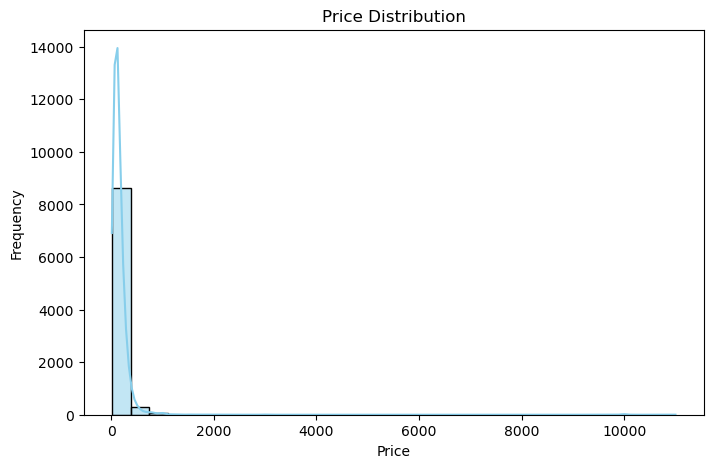

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

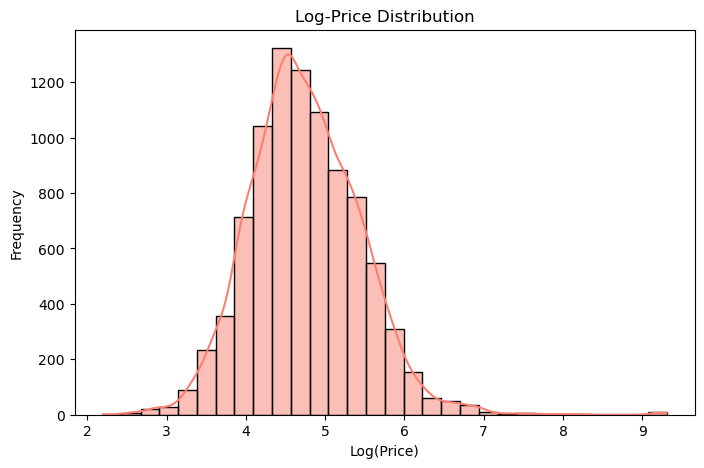

In [15]:
df['lnprice'] = np.log(df['price'])

plt.figure(figsize=(8, 5))
sns.histplot(df['lnprice'], bins=30, kde=True, color='salmon')
plt.title('Log-Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()

In [16]:
df = df[df['price'] <= 4000]

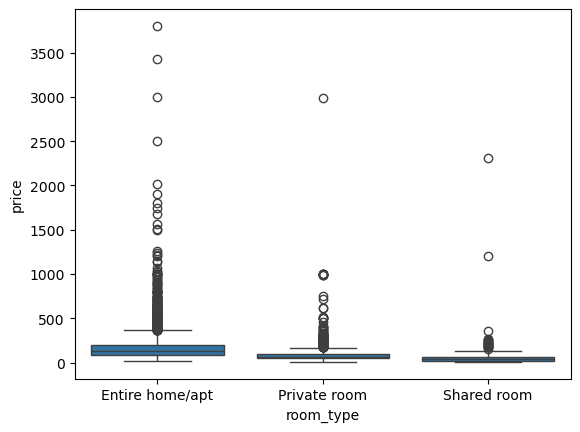

In [17]:
sns.boxplot(data = df, x = 'room_type', y = 'price', orient = 'v', order = ['Entire home/apt', 'Private room', 'Shared room'])
plt.show()


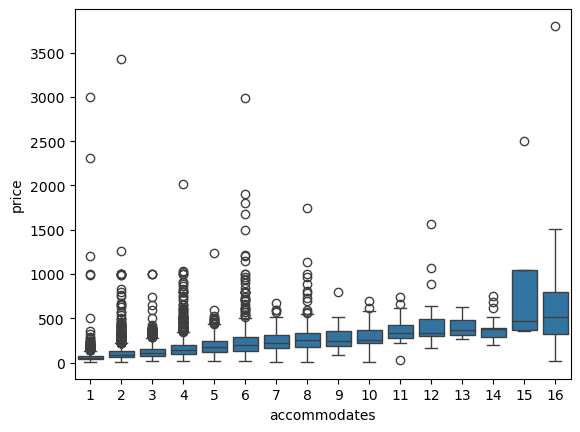

In [18]:
sns.boxplot(data = df, x = 'accommodates', y = 'price', orient = 'v')
plt.show()

In [19]:
all_property_types = sorted(df['property_type'].unique())
all_room_types = sorted(df['room_type'].unique())

# Convert the columns to categorical with these explicit levels
df['property_type'] = pd.Categorical(df['property_type'], categories=all_property_types)
df['room_type'] = pd.Categorical(df['room_type'], categories=all_room_types)

In [20]:
to_filter=df.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

license                        1986
host_location                  1983
last_review                    1980
review_scores_rating           1980
review_scores_value            1980
review_scores_location         1980
review_scores_communication    1980
review_scores_checkin          1980
review_scores_cleanliness      1980
review_scores_accuracy         1980
reviews_per_month              1980
first_review                   1980
host_response_rate             1149
host_response_time             1149
host_acceptance_rate            943
description                     523
has_availability                209
host_is_superhost               123
bathrooms_text                    5
dtype: int64

In [21]:
df.host_is_superhost = df.host_is_superhost.fillna('f')

In [22]:
df['host_is_superhost'] = df['host_is_superhost'].map({'f': 0, 't': 1})

In [23]:
# Factorize the host_response_time column (missing values are coded as -1)
codes, uniques = pd.factorize(df['host_response_time'])
df['host_response_time'] = codes

# Calculate the mean of the valid codes (excluding -1)
valid_mean = df.loc[df['host_response_time'] != -1, 'host_response_time'].mean()

# Replace missing values (coded as -1) with the computed mean
df.loc[df['host_response_time'] == -1, 'host_response_time'] = valid_mean

# Display the first few rows to verify the changes
df[['host_response_time', 'host_response_time']].head()

,host_response_time,host_response_time
0,0.0,0.0
1,1.0,1.0
2,1.0,1.0
3,2.0,2.0
4,1.0,1.0


In [24]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype(float)

In [25]:
df = df.fillna(df.mean(numeric_only=True))

In [26]:
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'f': 0, 't': 1})
df['host_identity_verified'] = df['host_identity_verified'].map({'f': 0, 't': 1})

In [27]:
df['last_review'] = pd.to_datetime(df['last_review'], format="%Y-%m-%d", errors='coerce')

# Find the latest date in the 'last_review' column
latest_date = df['last_review'].max()

# Create n_days_since: days between the latest date and each last_review date (min value becomes 0)
df['n_days_since'] = (latest_date - df['last_review']).dt.days

# Create n_accommodates2: 1 if 'accommodates' equals 2, else 0
df['n_accommodates2'] = (df['accommodates'] == 2).astype(int)

# Create n_days_since2: 1 if n_days_since equals 2, else 0
df['n_days_since2'] = (df['n_days_since'] == 2).astype(int)

# Create n_days_since3: 1 if n_days_since equals 3, else 0
df['n_days_since3'] = (df['n_days_since'] == 3).astype(int)

### Finding Interactions

In [28]:
basic_lev = (
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "n_days_since",
    "flag_days_since"
)
basic_add = ("bathrooms", "bedrooms", "host_is_superhost", "flag_reviews_per_month")
reviews = ("number_of_reviews", "review_scores_rating", "flag_review_scores_rating", "reviews_per_month")
host = ("host_response_time", "host_response_rate", "host_acceptance_rate", "host_has_profile_pic", "host_identity_verified")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3", "host_acceptance_rate")

In [29]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt



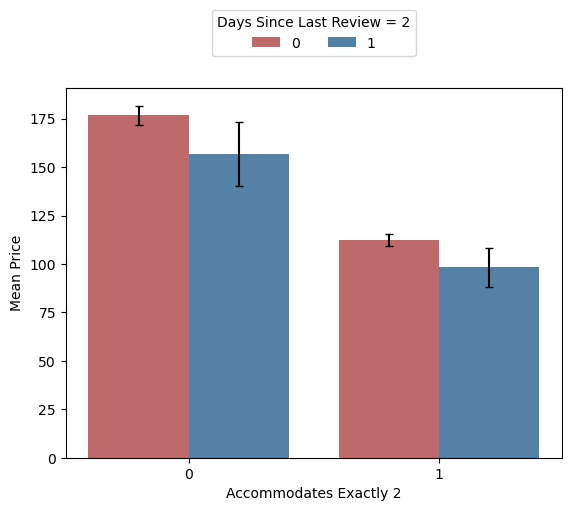

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [30]:
price_diff_by_variables(df, factor_var="n_accommodates2", dummy_var="n_days_since2", factor_lab="Accommodates Exactly 2", dummy_lab="Days Since Last Review = 2")

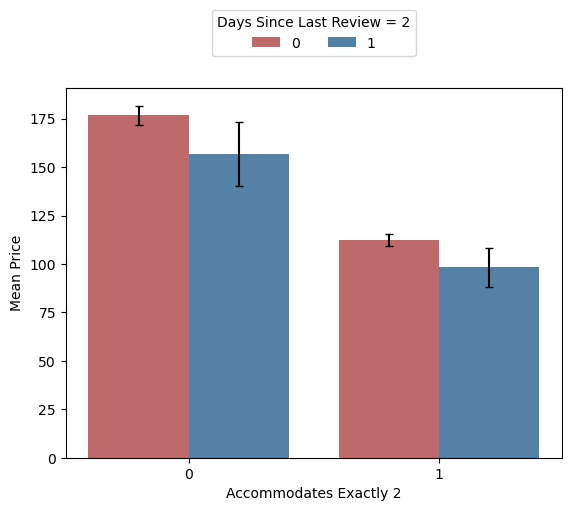

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [31]:
price_diff_by_variables(
    df=df,
    factor_var="n_accommodates2", 
    dummy_var="n_days_since2",
    factor_lab="Accommodates Exactly 2",
    dummy_lab="Days Since Last Review = 2"
)


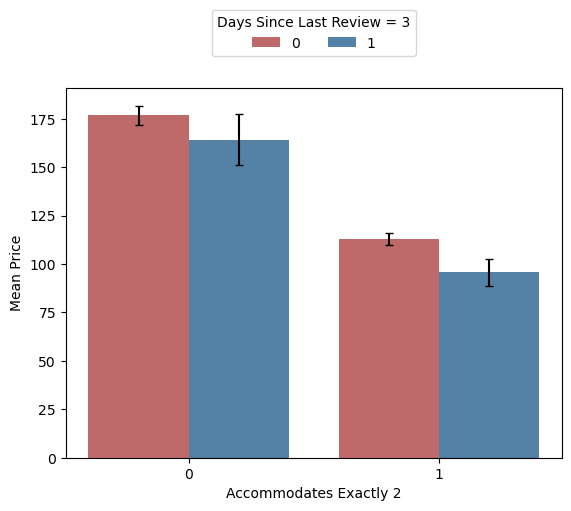

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [32]:
price_diff_by_variables(
    df=df,
    factor_var="n_accommodates2", 
    dummy_var="n_days_since3",
    factor_lab="Accommodates Exactly 2",
    dummy_lab="Days Since Last Review = 3"
)

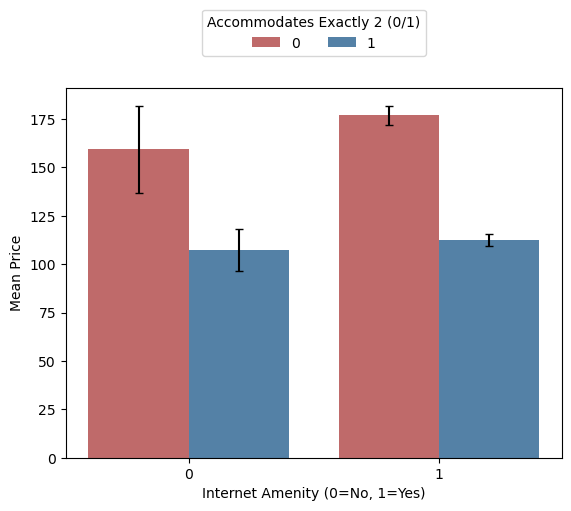

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [33]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_internet",       # 0: No internet, 1: Internet available
    dummy_var="n_accommodates2",          # 0: Not exactly 2, 1: Exactly 2
    factor_lab="Internet Amenity (0=No, 1=Yes)",
    dummy_lab="Accommodates Exactly 2 (0/1)"
)


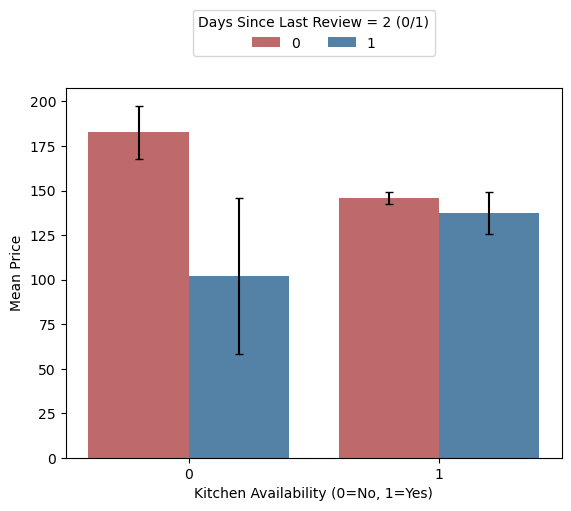

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [34]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_kitchen",         # 0: No kitchen, 1: Kitchen available
    dummy_var="n_days_since2",              # 0: n_days_since is not 2, 1: n_days_since equals 2
    factor_lab="Kitchen Availability (0=No, 1=Yes)",
    dummy_lab="Days Since Last Review = 2 (0/1)"
)

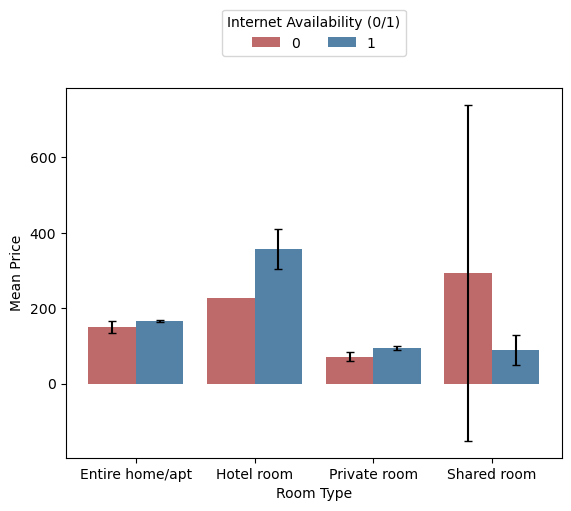

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [35]:
price_diff_by_variables(
    df=df,
    factor_var="room_type",              # Categorical variable: Room Type
    dummy_var="amenity_internet",        # Binary variable: Internet Availability (0 = No, 1 = Yes)
    factor_lab="Room Type",
    dummy_lab="Internet Availability (0/1)"
)

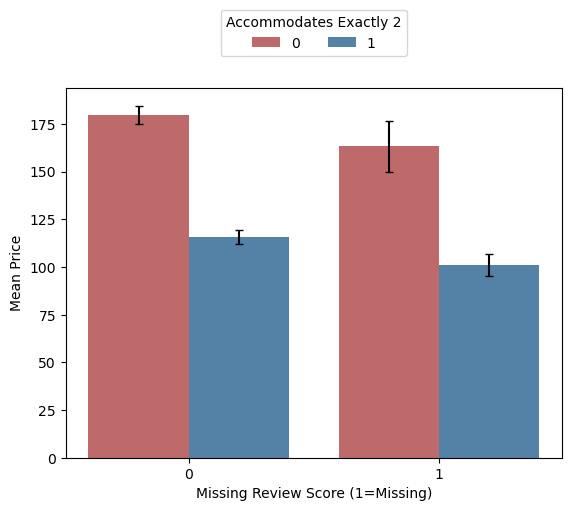

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [36]:
price_diff_by_variables(
    df=df,
    factor_var="flag_review_scores_rating", 
    dummy_var="n_accommodates2",
    factor_lab="Missing Review Score (1=Missing)",
    dummy_lab="Accommodates Exactly 2"
)

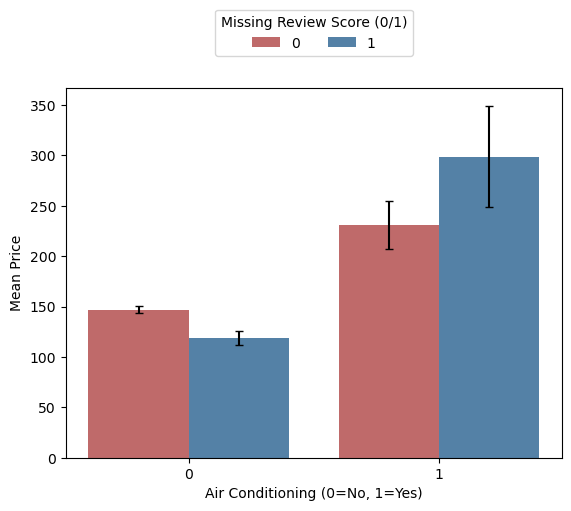

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [37]:
price_diff_by_variables(
    df=df,
    factor_var="amenity_air_conditioning",  # 0: No air conditioning, 1: Air conditioning available
    dummy_var="flag_review_scores_rating",    # 0: Review score available, 1: Review score missing
    factor_lab="Air Conditioning (0=No, 1=Yes)",
    dummy_lab="Missing Review Score (0/1)"
)

In [38]:
amenities = [col for col in df.columns if col.startswith("amenity_")]
print(amenities)

['amenity_internet', 'amenity_air_conditioning', 'amenity_heating', 'amenity_kitchen', 'amenity_parking', 'amenity_laundry', 'amenity_tv', 'amenity_elevator', 'amenity_pets', 'amenity_family', 'amenity_safety']


In [39]:
X1 = (
    "room_type*property_type",
    "room_type*amenity_family"
)

# X2: Interactions between property_type and selected amenity variables
X2 = (
    "amenity_air_conditioning*property_type",
    "amenity_pets*property_type"
)

# X3: A broad interaction between key categorical variables and all amenity variables.
# Since you do not have cancellation_policy, we use (property_type + room_type + bed_type)
X3 = "(property_type + room_type) * (" + " + ".join(amenities) + ")"

In [40]:
modellev1="~ accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(host)+"+"+"+".join(poly_lev)+"+"+"+".join(neighborhood_dummies)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)+"+"+X3

In [41]:
smp_size = round(0.2 * df.shape[0])-1
smp_size

1799

## OLS prediction

In [42]:
np.random.seed(20250217)

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
df_train, df_holdout = train_test_split( df, train_size=0.7, random_state = 20250224)

In [45]:
df_train.shape

(6299, 99)

In [46]:
df_holdout.shape

(2700, 99)

In [47]:
n_folds=5

In [48]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [49]:
def cv_reg(formula, df, kfold, testdf, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(df):
        df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = df_train).fit()
        else:
            model = smf.ols(formula, data = df_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(df_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [df_train["price"], model.predict(df_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [df_test["price"], model.predict(df_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [50]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, df, k, "HC0")]

In [51]:
summarize_cv(cv_list).map('{:,.3f}'.format)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,133.823,112.688,109.666,108.021,107.232,105.125,104.222,99.535
Fold2,127.617,116.420,112.861,111.956,111.718,110.647,109.859,104.453
Fold3,135.883,114.734,111.032,109.920,109.264,107.687,107.143,100.725
Fold4,141.651,121.751,118.344,117.318,116.805,115.319,114.645,108.986
Fold5,133.264,123.511,118.629,117.572,117.286,115.787,115.189,109.633
Average,134.448,117.821,114.106,112.957,112.461,110.913,110.211,104.666


In [52]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
df_rmse_levels = pd.DataFrame.from_dict(rmse_levels)
df_rmse_levels["nvars2"] = df_rmse_levels["nvars"] + 1

In [53]:
df_rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,134.447505,2
1,58,RMSE Training,117.820847,59
2,69,RMSE Training,114.106198,70
3,83,RMSE Training,112.957400,84
4,89,RMSE Training,112.460896,90
5,156,RMSE Training,110.913040,157
6,164,RMSE Training,110.211432,165
7,375,RMSE Training,104.666324,376
8,1,RMSE Test,133.769692,2
9,58,RMSE Test,122.461226,59


In [54]:
model2_train_rmse = pd.Series(cv_list[2]["rmse"]).mean()
model2_test_rmse = pd.Series(cv_list[2]["rmse_test"]).mean()

print("Model 3 RMSE Training: {:.3f}".format(model2_train_rmse))
print("Model 3 RMSE Test: {:.3f}".format(model2_test_rmse))

Model 3 RMSE Training: 114.106
Model 3 RMSE Test: 121.624


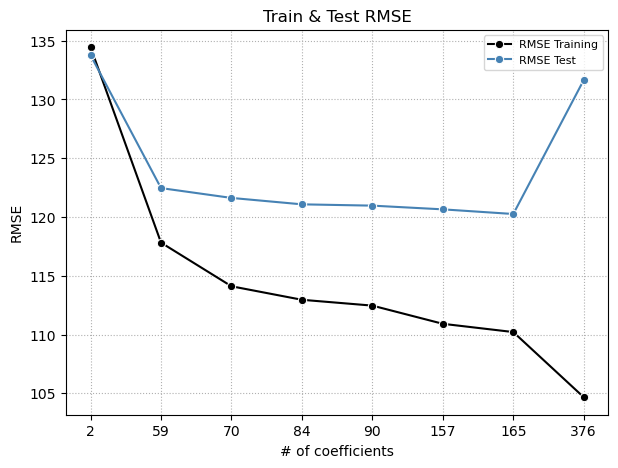

In [55]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    x = [str(x) for x in df_rmse_levels['nvars2']], 
    y = df_rmse_levels['value'], 
    hue = df_rmse_levels['var'], marker = 'o',
    palette = ['k', 'steelblue']
)
ax.set_title('Train & Test RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('# of coefficients')
ax.legend(fontsize = 8, title = None)
ax.grid(linestyle = ':')
plt.show();

## Lasso prediction

In [56]:
vars_model_8 = modellev8

In [57]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, df)

In [58]:
y

DesignMatrix with shape (7019, 1)
  price
    290
    240
    100
    186
     78
    152
    106
    107
    105
    180
     70
     90
     28
    227
     70
     53
    171
    290
    110
    199
    126
     65
    260
     70
    130
    126
     60
     19
    521
     90
  [6989 rows omitted]
  Terms:
    'price' (column 0)
  (to view full data, use np.asarray(this_obj))

In [59]:
X.shape

(7019, 934)

In [60]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [61]:
lambdas

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [62]:
train_r_squared

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [63]:
X.shape[1]

934

In [64]:
import datetime

In [65]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20250217) # In Python, Lasso's lambda is called alpha. Why?
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2025-03-03 03:32:09
Run:  1, lambda: 0.10, start: 2025-03-03 03:33:19
Run:  2, lambda: 0.15, start: 2025-03-03 03:34:38
Run:  3, lambda: 0.20, start: 2025-03-03 03:35:41
Run:  4, lambda: 0.25, start: 2025-03-03 03:36:27
Run:  5, lambda: 0.30, start: 2025-03-03 03:37:05
Run:  6, lambda: 0.35, start: 2025-03-03 03:37:35
Run:  7, lambda: 0.40, start: 2025-03-03 03:38:07
Run:  8, lambda: 0.45, start: 2025-03-03 03:38:45
Run:  9, lambda: 0.50, start: 2025-03-03 03:39:27
Run: 10, lambda: 0.55, start: 2025-03-03 03:39:52
Run: 11, lambda: 0.60, start: 2025-03-03 03:40:06
Run: 12, lambda: 0.65, start: 2025-03-03 03:40:20
Run: 13, lambda: 0.70, start: 2025-03-03 03:40:42
Run: 14, lambda: 0.75, start: 2025-03-03 03:41:03
Run: 15, lambda: 0.80, start: 2025-03-03 03:41:20
Run: 16, lambda: 0.85, start: 2025-03-03 03:41:36
Run: 17, lambda: 0.90, start: 2025-03-03 03:41:44
Run: 18, lambda: 0.95, start: 2025-03-03 03:41:51


In [66]:
results

array([0.30618272, 0.33295922, 0.30377314, 0.45796864, 0.29971145])

In [67]:
r_squared_df = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [68]:
r_squared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lambda    38 non-null     float64
 1   variable  38 non-null     object 
 2   value     38 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


In [69]:
r_squared_df["variable"] = r_squared_df["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [70]:
r_squared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lambda    38 non-null     float64 
 1   variable  38 non-null     category
 2   value     38 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 902.0 bytes


In [71]:
r_squared_df

,lambda,variable,value
0,0.05,$R^2$ Test set,0.266321
1,0.10,$R^2$ Test set,0.272658
2,0.15,$R^2$ Test set,0.276089
3,0.20,$R^2$ Test set,0.278914
4,0.25,$R^2$ Test set,0.281253
5,0.30,$R^2$ Test set,0.283215
6,0.35,$R^2$ Test set,0.284801
7,0.40,$R^2$ Test set,0.286143
8,0.45,$R^2$ Test set,0.287384
9,0.50,$R^2$ Test set,0.288476


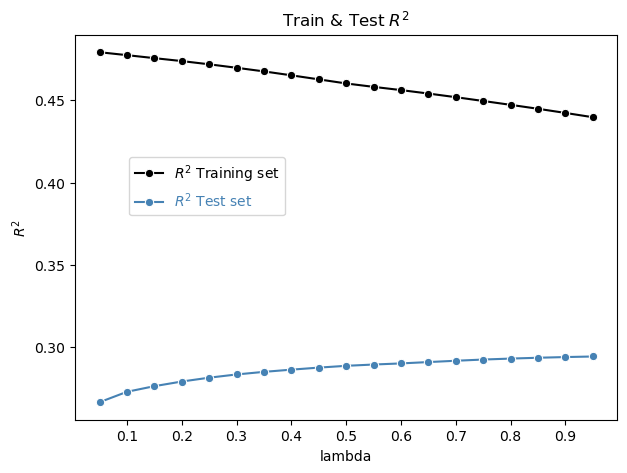

In [72]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    data = r_squared_df, 
    x = 'lambda', y = 'value', hue = 'variable', 
    palette = ['k', 'steelblue'],
    marker = 'o'
)
ax.set_title('Train & Test $R^2$')
ax.set_ylabel('$R^2$')
ax.set_xlabel('lambda')
ax.set_xticks(lambdas[1::2])
ax.legend(fontsize = 10, title = None, labelcolor = ['k', 'steelblue'], loc='upper right', bbox_to_anchor=(0.4, 0.7))
plt.show();

In [73]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    29.415189
lambda        0.950000
Name: 18, dtype: float64

In [74]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.95)

In [75]:
y_train_pred = reg_best.predict(X_train)

In [76]:
from sklearn.metrics import mean_squared_error

In [77]:
rmse_Lasso_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {rmse_Lasso_train:.3f}")

Training RMSE: 100.555


In [78]:
y_test_pred = reg_best.predict(X_test)

In [79]:
rmse_Lasso_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {rmse_Lasso_test:.3f}")

Test RMSE: 133.028


In [80]:
reg_best.coef_[reg_best.coef_>0]

array([3.68331322e+01, 4.45522049e+00, 5.13698913e+01, 5.62688293e-01,
       1.24611931e+01, 1.45420639e+01, 4.52074088e+00, 6.93719312e+00,
       4.98389710e-01, 2.62323844e+00, 5.18467291e+00, 5.19284153e+00,
       8.08741982e-01, 8.04952426e+00, 6.49575991e+00, 8.14669375e-02,
       9.14065764e-01, 2.11019580e-01, 2.25839167e+00, 2.70157030e+00,
       3.66683906e+00, 3.86679812e+00, 1.11013892e-02, 1.22532460e+00,
       7.80577868e+00, 3.31370903e+00, 5.38690828e+00, 1.89725358e+01,
       1.35216336e+00, 2.56745952e+00, 1.39016532e+00, 1.83066793e+00,
       4.38273182e+00, 2.49519186e+01, 8.45542214e+00, 8.73186304e-02,
       3.02747520e+00, 4.99707334e+00, 1.42781431e-02, 5.83814456e+00,
       1.71317835e-04, 2.14324369e+00, 2.70231056e-01, 3.83707720e+00,
       6.39026176e+00, 5.43477635e+00, 6.37691737e-01, 2.00433494e+00,
       9.09694057e-03, 5.46935344e+00, 5.06701591e-03, 4.30712450e+00,
       5.41820670e-01, 4.25425966e-02, 2.37607833e+00, 1.26079589e-01,
      

In [81]:
print(reg_best.coef_)

[ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  3.68331322e+01  0.00000000e+00 -0.00000000e+00  4.45522049e+00
 -0.00000000e+00  0.00000000e+00 -9.26862392e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.18801787e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -6.38539212e-02  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.04853144e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.42241539e+00
 -0.00000000e+00  0.00000

In [82]:
reg_best.get_params()

{'alpha': 0.95,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

## LASSO using `GridSearch`

In [83]:
from sklearn.metrics import mean_squared_error

print(f'{mean_squared_error(y_test, reg_best.predict(X_test)):,.2f}')

17,696.57


In [84]:
y,  X = patsy.dmatrices('price'+vars_model_8, df)

In [85]:
vars_model_8

'~accommodates+beds+property_type+room_type+n_days_since+flag_days_since+bathrooms+bedrooms+host_is_superhost+flag_reviews_per_month+number_of_reviews+review_scores_rating+flag_review_scores_rating+reviews_per_month+host_response_time+host_response_rate+host_acceptance_rate+host_has_profile_pic+host_identity_verified+n_accommodates2+n_days_since2+n_days_since3+host_acceptance_rate+neighbourhood_group_Friedrichshain_Kreuzberg+neighbourhood_group_Lichtenberg+neighbourhood_group_Marzahn___Hellersdorf+neighbourhood_group_Mitte+neighbourhood_group_Neukölln+neighbourhood_group_Pankow+neighbourhood_group_Reinickendorf+neighbourhood_group_Spandau+neighbourhood_group_Steglitz___Zehlendorf+neighbourhood_group_Tempelhof___Schöneberg+neighbourhood_group_Treptow___Köpenick+room_type*property_type+room_type*amenity_family+amenity_air_conditioning*property_type+amenity_pets*property_type+amenity_internet+amenity_air_conditioning+amenity_heating+amenity_kitchen+amenity_parking+amenity_laundry+amenity_

In [86]:
X.shape

(7019, 934)

In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
%%time

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END .....................alpha=0.05;, score=-140.590 total time=   3.3s
[CV 2/5] END .....................alpha=0.05;, score=-107.154 total time=   3.0s
[CV 3/5] END .....................alpha=0.05;, score=-113.666 total time=   2.5s
[CV 4/5] END .....................alpha=0.05;, score=-102.672 total time=   3.0s
[CV 5/5] END .....................alpha=0.05;, score=-112.087 total time=   2.2s
[CV 1/5] END ......................alpha=0.1;, score=-140.149 total time=   3.1s
[CV 2/5] END ......................alpha=0.1;, score=-102.800 total time=   3.2s
[CV 3/5] END ......................alpha=0.1;, score=-113.631 total time=   0.7s
[CV 4/5] END ......................alpha=0.1;, score=-103.259 total time=   3.1s
[CV 5/5] END ......................alpha=0.1;, score=-112.105 total time=   2.8s
[CV 1/5] END ......alpha=0.15000000000000002;, score=-140.013 total time=   1.1s
[CV 2/5] END ......alpha=0.15000000000000002;, s

In [89]:
print(f'RMSE: {(results.best_score_ * -1):,.3f}')

RMSE: 114.069


In [90]:
results.cv_results_['rank_test_score']

array([10,  4,  1,  2,  3,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19], dtype=int32)

In [91]:
grid

{'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])}

In [92]:
results.best_estimator_

Lasso(alpha=0.15000000000000002)

In [93]:
model3_level = smf.ols('price'+modellev3, data=df_train).fit(cov_type='HC0')
model7_level = smf.ols('price'+modellev7, data=df_train).fit(cov_type='HC0')

In [94]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [df_train["price"], model7_level.predict(df_train)],
    axis=1,
    keys=["price", "predicted"],
)

In [95]:
model7_level_work_predictions.tail()

,price,predicted
175,60.0,25.899131
1290,49.0,51.708123
9689,80.0,162.449365
8063,135.0,134.386359
366,190.0,85.513801


In [96]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [97]:
model7_level_work_rmse

116.63899726247683

In [98]:
model7_level_holdout_predictions = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

RMSE work:116.64 	 RMSE holdout:100.78


In [99]:
Ylev=df_holdout['price']
"""meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)"""

'meanY=Ylev.mean()\nsdY=Ylev.std()\nmeanY_m2SE = meanY -1.96 * sdY\nmeanY_p2SE = meanY + 1.96 * sdY\nY5p=Ylev.quantile(.05)\nY95p=Ylev.quantile(.95)'

In [100]:
model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,137.601079,6.279479,125.293526,149.908632,-95.084917,370.287075
1,104.427767,13.708943,77.558733,131.296800,-129.480852,338.336385
2,147.849119,11.405990,125.493789,170.204449,-85.584078,381.282316
3,79.852895,6.443897,67.223089,92.482700,-152.850369,312.556158
4,292.674311,12.221432,268.720745,316.627876,59.082637,526.265985
...,...,...,...,...,...,...
2113,130.341181,9.878967,110.978761,149.703602,-102.824425,363.506788
2114,65.314659,8.387875,48.874727,81.754592,-167.626467,298.255785
2115,124.925425,17.954642,89.734974,160.115875,-110.084500,359.935349
2116,230.864828,33.237546,165.720435,296.009221,-10.454646,472.184303


In [101]:
# Create df frame with the real and predicted values
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [102]:
df_.isna().sum()

price          0
predicted    582
dtype: int64

In [103]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["Ylev"] = df_["price"]

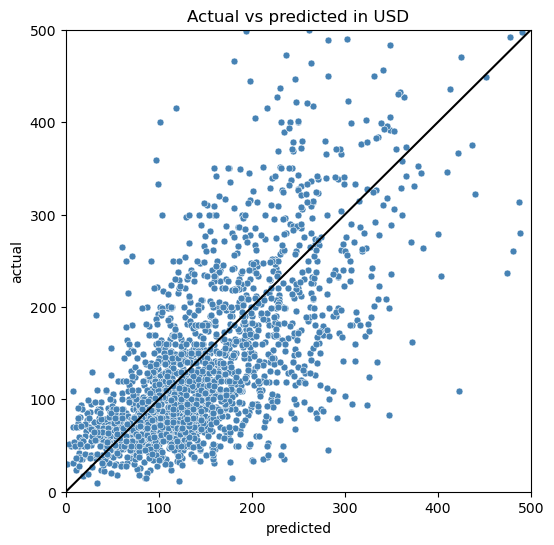

In [104]:
x = np.linspace(0, 500, df_diagnostic.shape[0])

plt.figure(figsize = (6,6))
ax = sns.scatterplot(
    data=df_diagnostic, x="mean", y="Ylev",
    s = 25, color = 'steelblue'
)
plt.plot(x,x, color = 'k')
ax.set_xlim(0,500)
ax.set_ylim(0,500)
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.set_title('Actual vs predicted in USD')
plt.show()

In [105]:
dt = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_extra = pd.concat(
    [
        df_holdout["price"],
        df_holdout["accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "accommodates", "predicted"],
)
df_extra = df_extra[~df_extra.isna().any(axis=1)].reset_index(drop=True)
dt["accommodates"] = df_extra["accommodates"]
dt["Ylev"] = df_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]

In [106]:
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_ = pd.concat(
    [
        df_holdout["price"],
        df_holdout["accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "accommodates", "predicted"],
)
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["accommodates"] = df_["accommodates"]
df_diagnostic["Ylev"] = df_["price"]
df_diagnostic["elev"] = df_diagnostic["Ylev"] - df_diagnostic["mean"]

In [107]:
predictionlev_holdout_summary = df_diagnostic.groupby(by=["accommodates"]).mean().reset_index()

In [108]:
predictionlev_holdout_summary

,accommodates,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Ylev,elev
0,1,62.603530,19.764244,37.274633,87.932428,-92.707423,217.914484,66.947090,4.343560
1,2,115.264995,16.431221,94.207538,136.322453,-39.117480,269.647471,112.982437,-2.282558
2,3,137.837332,16.954650,116.109073,159.565590,-16.550875,292.225538,130.707317,-7.130014
3,4,174.807942,16.859468,153.201664,196.414219,20.151559,329.464324,169.814536,-4.993405
4,5,214.936533,17.503270,192.505191,237.367876,60.518230,369.354837,213.990826,-0.945708
5,6,232.681205,17.859045,209.793918,255.568493,78.065821,387.296590,249.677215,16.996010
6,7,248.819545,16.346050,227.871239,269.767850,95.007871,402.631219,240.418605,-8.400940
7,8,266.029840,23.600169,235.785007,296.274673,109.603275,422.456405,289.062500,23.032660
8,9,341.025016,27.269907,306.077224,375.972808,182.857959,499.192073,274.727273,-66.297743
9,10,335.642668,21.058969,308.654514,362.630822,180.859863,490.425473,339.428571,3.785903


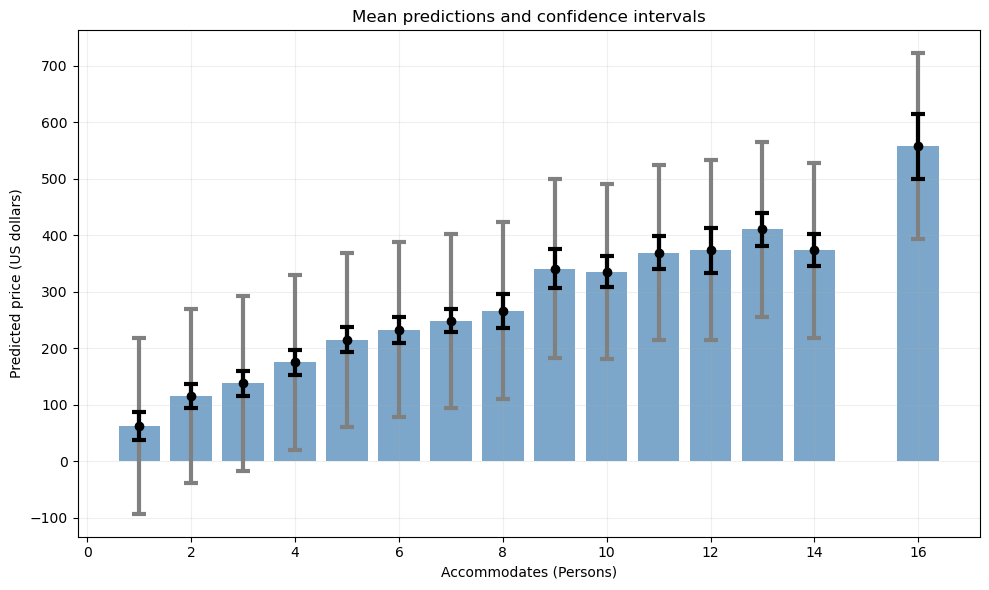

In [109]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for mean values
ax.bar(predictionlev_holdout_summary['accommodates'],
       predictionlev_holdout_summary['mean'],
       color='steelblue',
       alpha=0.7)

# Plot error bars for observations
ax.errorbar(predictionlev_holdout_summary['accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['obs_ci_lower'],
                  predictionlev_holdout_summary['obs_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='none',
            color='grey',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Plot error bars for means
ax.errorbar(predictionlev_holdout_summary['accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['mean_ci_lower'],
                  predictionlev_holdout_summary['mean_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='bo',
            color='k',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Customize axes and labels
ax.set_xlabel('Accommodates (Persons)')
ax.set_ylabel('Predicted price (US dollars)')
ax.set_title('Mean predictions and confidence intervals')

# Set style similar to theme_bw()
ax.grid(True, linestyle='-', alpha=0.2)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('black')

# Adjust layout
plt.tight_layout()

# Return the plot


## Random Forest

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from patsy import dmatrices, dmatrix
import matplotlib.ticker as mtick

In [111]:
df.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    8,999.0
mean       148.5
std        149.7
min          9.0
1%          26.0
10%         50.0
25%         72.0
50%        110.0
75%        180.0
90%        276.0
99%        714.1
max      3,800.0
Name: price, dtype: object

In [112]:
df_train.shape, df_holdout.shape

((6299, 99), (2700, 99))

In [113]:
to_filter=df.isna().sum()
to_filter[to_filter>0].sort_values(ascending = False)

license             1986
host_location       1983
first_review        1980
last_review         1980
n_days_since        1980
description          523
has_availability     209
bathrooms_text         5
dtype: int64

In [114]:
# basic variables inc neighbourhood
basic_vars = [
    "accommodates",
    "beds",
    "n_days_since",
    "property_type",
    "room_type",
    "bathrooms",
    "bedrooms",
    "neighbourhood_cleansed",
]

# reviews
reviews = [
    "number_of_reviews",
    "flag_reviews_per_month",
    "review_scores_rating",
    "flag_review_scores_rating",
]

host = [
    "host_response_time", 
    "host_response_rate",
    "host_acceptance_rate",
    "host_has_profile_pic", 
    "host_identity_verified"]

# dummy variables
amenities = [col for col in df if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "room_type:amenity_family",
    "amenity_air_conditioning:property_type",
    "amenity_pets:property_type"
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

In [115]:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]

In [116]:
print(df['neighbourhood_group_cleansed'].unique())

['Pankow' 'Friedrichshain-Kreuzberg' 'Mitte' 'Charlottenburg-Wilm.'
 'Neukölln' 'Tempelhof - Schöneberg' 'Steglitz - Zehlendorf'
 'Treptow - Köpenick' 'Spandau' 'Lichtenberg' 'Reinickendorf'
 'Marzahn - Hellersdorf']


In [117]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host + amenities
predictors_E = basic_vars + reviews + host + amenities + X1 + X2

In [118]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), df_train, return_type='dataframe')
print("Training design matrix shape:", X.shape)  # e.g., (4810, 209)

# Build holdout design matrices from df_holdout
y_h, X_h = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
print("Holdout design matrix shape (before reindexing):", X_h.shape)  # e.g., (2083, 204)

# Convert the holdout design matrix into a DataFrame with the expected column names from training
X_h_df = pd.DataFrame(X_h, columns=X.design_info.column_names)

# Reindex the holdout DataFrame to ensure it has all columns from the training matrix, filling missing columns with 0
X_h_df = X_h_df.reindex(columns=X.columns, fill_value=0)
print("Holdout design matrix shape (after reindexing):", X_h_df.shape)  # Now (2083, 209)

Training design matrix shape: (4901, 209)
Holdout design matrix shape (before reindexing): (2118, 206)
Holdout design matrix shape (after reindexing): (2118, 209)


In [119]:
X.design_info.column_names

['Intercept',
 'property_type[T.Camper/RV]',
 'property_type[T.Casa particular]',
 'property_type[T.Dome]',
 'property_type[T.Entire bungalow]',
 'property_type[T.Entire cabin]',
 'property_type[T.Entire chalet]',
 'property_type[T.Entire condo]',
 'property_type[T.Entire cottage]',
 'property_type[T.Entire guest suite]',
 'property_type[T.Entire guesthouse]',
 'property_type[T.Entire home]',
 'property_type[T.Entire loft]',
 'property_type[T.Entire place]',
 'property_type[T.Entire rental unit]',
 'property_type[T.Entire serviced apartment]',
 'property_type[T.Entire townhouse]',
 'property_type[T.Entire vacation home]',
 'property_type[T.Entire villa]',
 'property_type[T.Farm stay]',
 'property_type[T.Houseboat]',
 'property_type[T.Island]',
 'property_type[T.Private room]',
 'property_type[T.Private room in bed and breakfast]',
 'property_type[T.Private room in boat]',
 'property_type[T.Private room in bungalow]',
 'property_type[T.Private room in casa particular]',
 'property_type[

In [120]:
X.shape

(4901, 209)

In [121]:
import math

In [122]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 14.46.


In [123]:
rfr = RandomForestRegressor(random_state = 20250224)

In [124]:
tune_grid = {"max_features": [11, 13, 15, 17], "min_samples_leaf": [5, 10, 15]}
tune_grid

{'max_features': [11, 13, 15, 17], 'min_samples_leaf': [5, 10, 15]}

In [125]:
rf_random = GridSearchCV(
    estimator = rfr,
    param_grid = tune_grid,
    cv = 5,
    scoring = "neg_root_mean_squared_error",
    verbose = 3,
)

In [126]:
rf_model = rf_random.fit(X, y.values.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=11, min_samples_leaf=5;, score=-137.706 total time=   0.3s
[CV 2/5] END max_features=11, min_samples_leaf=5;, score=-130.892 total time=   0.2s
[CV 3/5] END max_features=11, min_samples_leaf=5;, score=-99.103 total time=   0.2s
[CV 4/5] END max_features=11, min_samples_leaf=5;, score=-144.114 total time=   0.2s
[CV 5/5] END max_features=11, min_samples_leaf=5;, score=-91.224 total time=   0.2s
[CV 1/5] END max_features=11, min_samples_leaf=10;, score=-140.301 total time=   0.1s
[CV 2/5] END max_features=11, min_samples_leaf=10;, score=-135.451 total time=   0.1s
[CV 3/5] END max_features=11, min_samples_leaf=10;, score=-102.230 total time=   0.1s
[CV 4/5] END max_features=11, min_samples_leaf=10;, score=-146.260 total time=   0.1s
[CV 5/5] END max_features=11, min_samples_leaf=10;, score=-94.657 total time=   0.1s
[CV 1/5] END max_features=11, min_samples_leaf=15;, score=-142.384 total time=   0.1s
[

In [127]:
rf_model.cv_results_

{'mean_fit_time': array([0.18473234, 0.12171412, 0.10832348, 0.15970178, 0.15209856,
        0.12039008, 0.18050337, 0.14737873, 0.13535929, 0.19028859,
        0.16534014, 0.14873261]),
 'std_fit_time': array([0.04469881, 0.00331201, 0.00354368, 0.00357749, 0.03268716,
        0.00315191, 0.00350123, 0.00245045, 0.00921584, 0.00330705,
        0.0192548 , 0.01612901]),
 'mean_score_time': array([0.00717821, 0.00528979, 0.00491495, 0.00657024, 0.00578661,
        0.00517335, 0.00707011, 0.00591936, 0.00544662, 0.00705099,
        0.00587206, 0.00558252]),
 'std_score_time': array([3.90785219e-04, 1.21016818e-04, 1.28687333e-04, 9.87923970e-05,
        1.43498944e-04, 2.23048582e-04, 1.43766712e-04, 1.62874800e-04,
        1.00512975e-04, 4.12680453e-05, 8.60083120e-05, 1.27435513e-04]),
 'param_max_features': masked_array(data=[11, 11, 11, 13, 13, 13, 15, 15, 15, 17, 17, 17],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, F

In [128]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [129]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [130]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,11,5,-120.607945
1,11,10,-123.779883
2,11,15,-125.957101
3,13,5,-119.988141
4,13,10,-122.806846
5,13,15,-124.454620
6,15,5,-119.065663
7,15,10,-121.671217
8,15,15,-123.589784
9,17,5,-118.523980


In [131]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
11,120.61,123.78,125.96
13,119.99,122.81,124.45
15,119.07,121.67,123.59
17,118.52,121.39,123.05


In [132]:
rmse_rf_train = - rf_model.best_score_
rmse_rf_train

118.52397989410565

In [133]:
y_train_pred_rf = rf_model.best_estimator_.predict(X)
rmse_rf_train = np.sqrt(mean_squared_error(y, y_train_pred_rf))
print(f"RF Training RMSE: {rmse_rf_train:.3f}")

RF Training RMSE: 110.247


In [134]:
rf_model.best_params_

{'max_features': 17, 'min_samples_leaf': 5}

In [135]:
rf_model.best_estimator_

RandomForestRegressor(max_features=17, min_samples_leaf=5,
                      random_state=20250224)

In [136]:
pred = rf_model.predict(X_h_df)

In [137]:
from statsmodels.tools.eval_measures import rmse

In [138]:
rmse(y_test, pred)

array([161.95884991, 176.66885152, 158.76975192, ..., 159.30355132,
       211.46727604, 158.35235012])

In [139]:
rmse_rf_hold = mean_squared_error(y_h, pred, squared=False)
rmse_rf_hold

101.03687287549145

In [140]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.25331282e-03,
       0.00000000e+00, 1.11983728e-05, 5.50143416e-04, 1.15740322e-03,
       4.63804146e-03, 3.29134141e-03, 1.08878285e-02, 4.73209977e-02,
       0.00000000e+00, 7.92172320e-05, 0.00000000e+00, 0.00000000e+00,
       7.13406936e-03, 0.00000000e+00, 2.82724020e-06, 8.83682249e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.46728487e-03, 0.00000000e+00,
       8.21800281e-05, 2.89510451e-03, 5.12425518e-04, 0.00000000e+00,
       1.45529502e-05, 8.54825431e-06, 4.92429789e-02, 3.68461505e-05,
       1.20815946e-04, 0.00000000e+00, 0.00000000e+00, 1.04703718e-03,
       1.86606143e-03, 0.00000000e+00, 1.51315378e-02, 1.08104645e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.02486033e-03,
       0.00000000e+00, 0.00000000e+00, 1.45795997e-04, 0.00000000e+00,
      

In [141]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Camper/RV],0.000000
property_type[T.Casa particular],0.000000
property_type[T.Dome],0.000000
property_type[T.Entire bungalow],0.000000
...,...
host_response_time,0.028044
host_response_rate,0.022278
host_acceptance_rate,0.058613
host_has_profile_pic,0.000155


In [142]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [143]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,15.0%,15.0%
1,bedrooms,13.5%,28.5%
2,bathrooms,9.8%,38.3%
3,n_days_since,9.1%,47.3%
4,beds,7.4%,54.7%
5,host_acceptance_rate,5.9%,60.6%
6,property_type[T.Private room in rental unit],4.9%,65.5%
7,property_type[T.Entire serviced apartment],4.7%,70.2%
8,number_of_reviews,3.9%,74.1%
9,review_scores_rating,3.3%,77.4%


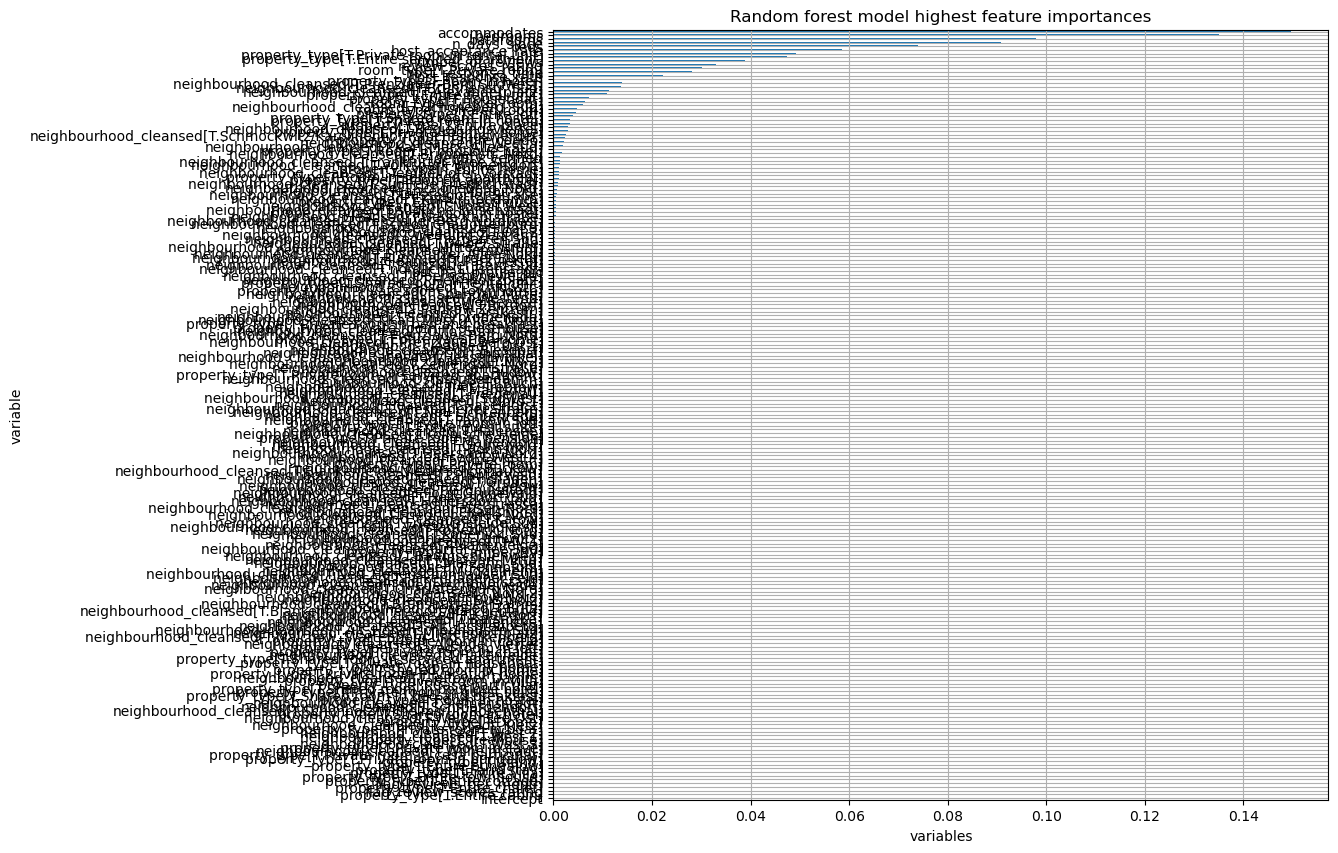

In [144]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [145]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

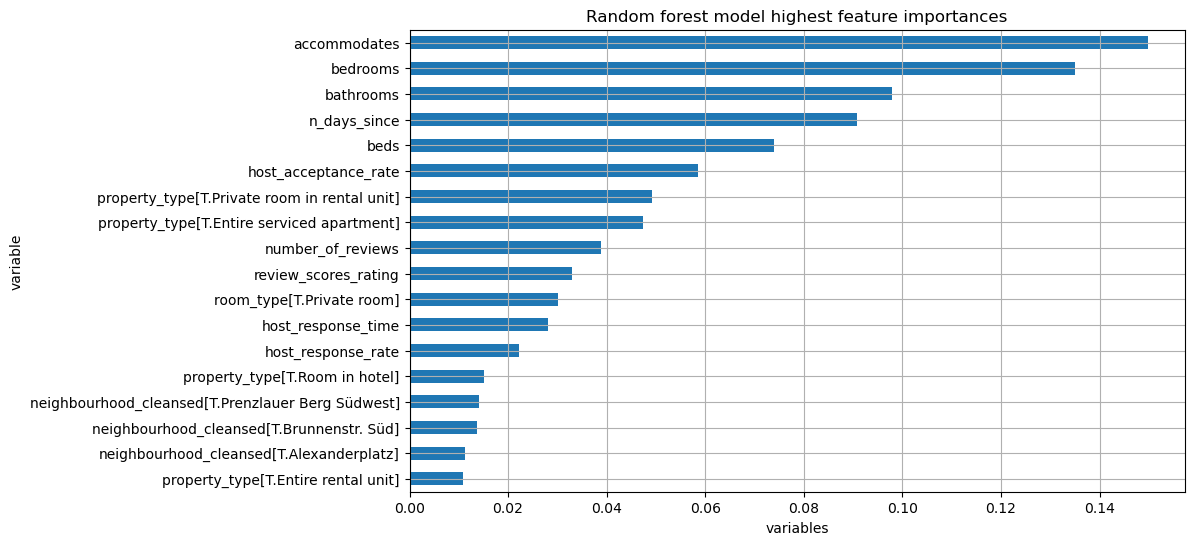

In [146]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

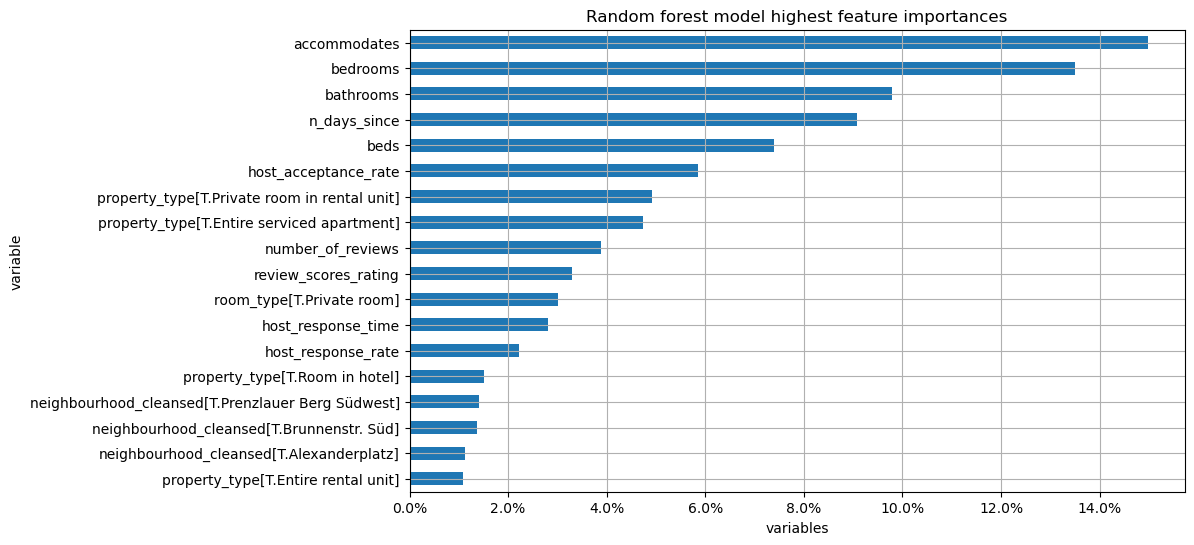

In [147]:
ax = df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh',
          x = 'variable', 
          y = 'imp',
          figsize = (10,6), 
          grid = True,
          title = 'Random forest model highest feature importances',
          xlabel = 'variables', 
          legend = False)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

In [148]:
categorical_columns = [
    "property_type",
    "room_type",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [149]:
numerical_columns

['accommodates',
 'beds',
 'n_days_since',
 'bathrooms',
 'bedrooms',
 'number_of_reviews',
 'flag_reviews_per_month',
 'review_scores_rating',
 'flag_review_scores_rating',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_identity_verified']

In [150]:
categorical_columns

['property_type', 'room_type', 'neighbourhood_cleansed']

In [151]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [152]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
])

# Create a categorical pipeline using OneHotEncoder (which can handle missing values by ignoring unknowns)
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# Combine numerical and categorical transformers in a ColumnTransformer
preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, numerical_columns),
        ("cat", cat_pipeline, categorical_columns)
    ]
)

# Create the full pipeline, using your best RandomForest model from tuning:
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessing), 
        ("regressor", rf_model.best_estimator_)  # your tuned RF model
    ]
)

# Fit the pipeline on the training data
rf_pipeline.fit(df_train[predictors_2], df_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['accommodates', 'beds',
                                                   'n_days_since', 'bathrooms',
                                                   'bedrooms',
                                                   'number_of_reviews',
                                                   'flag_reviews_per_month',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_response_time',
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed'])])),
                ('regressor',
                 RandomForestRegressor(max_features=17, min_samples_leaf=5,
                                       random_state=20250224))])

In [153]:
%%time
result = permutation_importance(
    rf_pipeline,
    df_holdout[predictors_2],
    df_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: user 3.32 s, sys: 22.4 ms, total: 3.34 s
Wall time: 3.41 s


In [154]:
pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)

,0
accommodates,0.065137
beds,0.015006
n_days_since,0.013814
property_type,0.059483
room_type,0.039680
bathrooms,0.041137
bedrooms,0.030708
neighbourhood_cleansed,0.020282
number_of_reviews,0.006711
flag_reviews_per_month,0.001362


In [155]:
grouped = [
    "property_type",
    "room_type",
    "bathrooms",
    "n_days_since",
    "accommodates",
    "beds",
    "neighbourhood_cleansed",
    "bedrooms",
    'number_of_reviews',
    'review_scores_rating',
    'host_response_rate',
    'host_acceptance_rate',
]

In [156]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [157]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,6.5%,6.5%
1,property_type,5.9%,12.5%
2,bathrooms,4.1%,16.6%
3,room_type,4.0%,20.5%
4,bedrooms,3.1%,23.6%
5,neighbourhood_cleansed,2.0%,25.6%
6,host_acceptance_rate,1.9%,27.6%
7,beds,1.5%,29.1%
8,n_days_since,1.4%,30.4%
9,host_response_rate,0.7%,31.2%


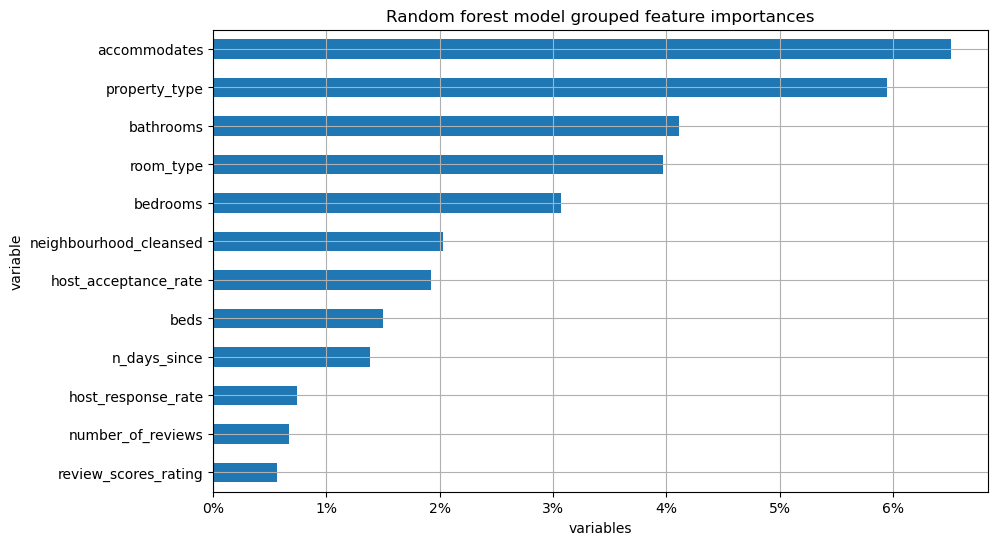

In [158]:
ax = df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         )
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [159]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        df_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,accommodates,0.065137,0.149746
1,property_type,0.059483,0.284794
2,bathrooms,0.041137,0.382628
3,room_type,0.039680,0.473336
4,bedrooms,0.030708,0.547242
5,neighbourhood_cleansed,0.020282,0.605855
6,host_acceptance_rate,0.019231,0.655098
7,host_response_time,0.016607,0.702419
8,beds,0.015006,0.741243
9,n_days_since,0.013814,0.774225


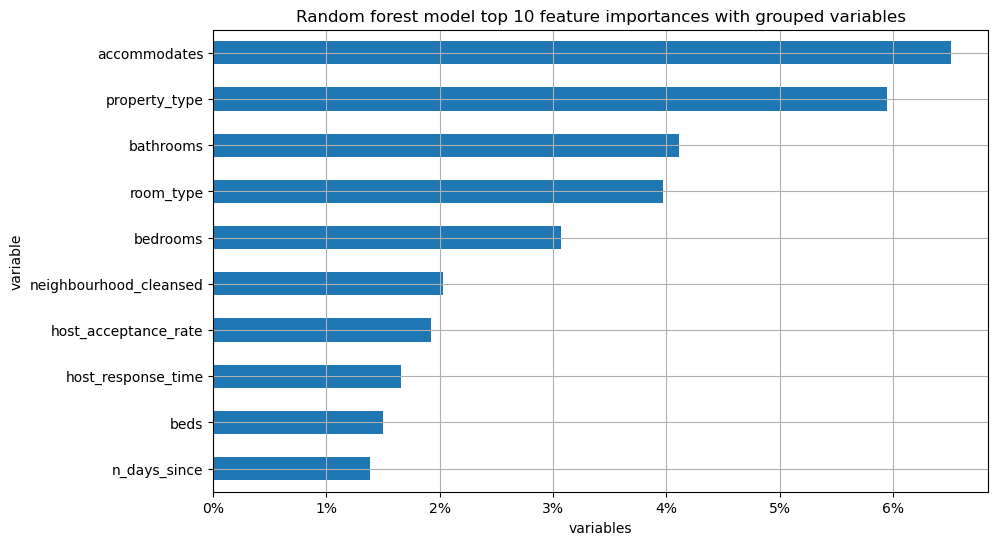

In [160]:
ax = df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         )
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals = 0));

In [161]:
accomodates_pdp = partial_dependence(
    rf_pipeline, df_holdout[predictors_2], ["accommodates"], kind="average"
)

In [162]:
accomodates_pdp

{'grid_values': [array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16])],
 'average': array([[129.61756058, 135.59220438, 140.86578825, 155.49904286,
         162.92530732, 182.07686335, 186.35455268, 189.42456003,
         192.4164012 , 197.80361466, 207.78075707, 212.06244617,
         212.29395106, 220.05107481, 220.3839493 ]])}

In [163]:
type(accomodates_pdp)

sklearn.utils._bunch.Bunch

In [164]:
pd.DataFrame({
    'number of accommodates': accomodates_pdp['grid_values'][0],
    'average price': accomodates_pdp['average'][0]
})

,number of accommodates,average price
0,1,129.617561
1,2,135.592204
2,3,140.865788
3,4,155.499043
4,5,162.925307
5,6,182.076863
6,7,186.354553
7,8,189.424560
8,9,192.416401
9,10,197.803615


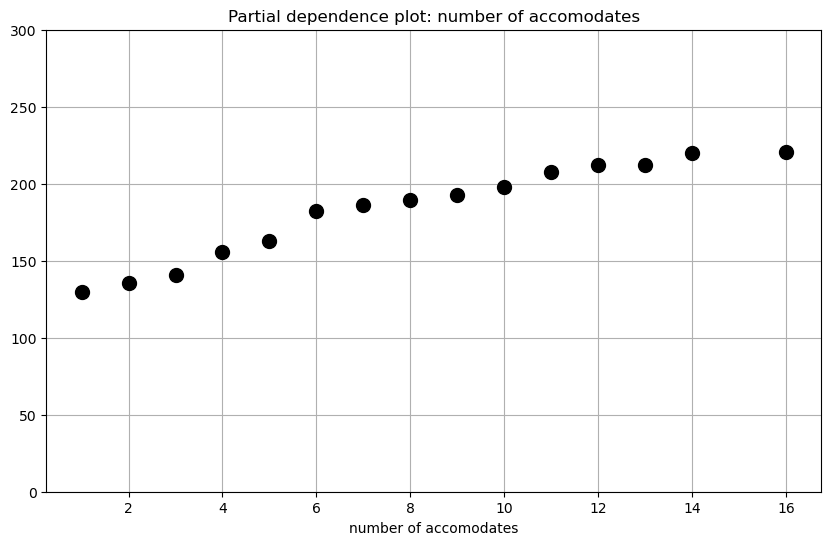

In [165]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['grid_values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 300), 
    title = 'Partial dependence plot: number of accomodates'
);

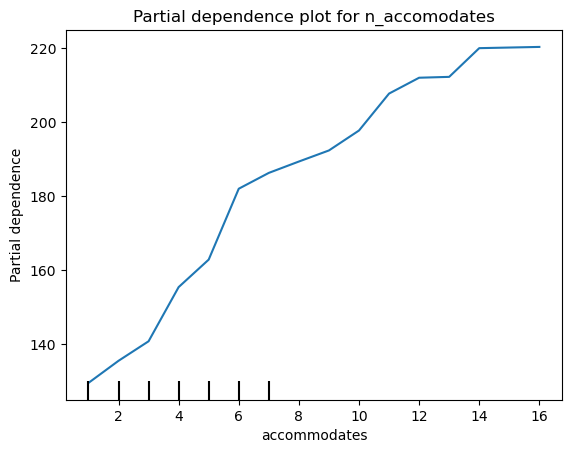

In [166]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = df_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

In [167]:
roomtype_pdp = partial_dependence(
    rf_pipeline, df_holdout[predictors_2], ["room_type"], kind="average"
)

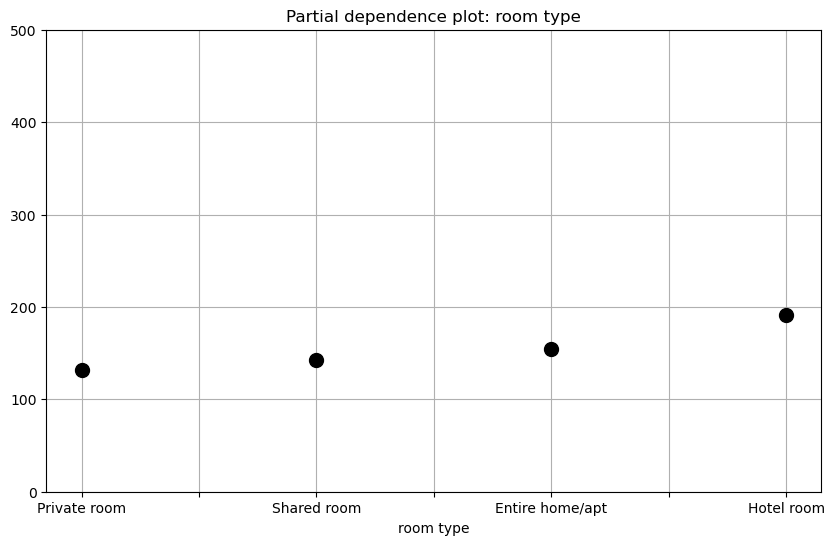

In [168]:
pd.DataFrame(
    {'room type': roomtype_pdp['grid_values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 500), 
    title = 'Partial dependence plot: room type'
);

In [169]:
df_holdout_w_prediction = df_holdout.assign(
    predicted_price=rf_pipeline.predict(df_holdout[predictors_2])
)

In [170]:
df_holdout_w_prediction['is_low_size'] = df_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [171]:
df_holdout_w_prediction.iloc[0:5, -5:]

,n_accommodates2,n_days_since2,n_days_since3,predicted_price,is_low_size
9208,1,0,0,187.667293,small apt
7822,1,0,0,75.423917,small apt
11781,0,0,0,165.980856,large apt
5436,1,0,0,88.793733,small apt
12347,1,0,0,234.052262,small apt


In [172]:
df_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    161.994829
small apt    101.825848
dtype: float64

In [173]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
    )

In [174]:
# cheaper or more expensive flats - not used in book
grouped_object = df_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [175]:
accom_subset

,rmse,mean_price,rmse_normalized
is_low_size,,,
large apt,178.13,218.51,0.82
small apt,98.25,108.27,0.91


In [176]:
unique_neighbourhoods = df['neighbourhood_cleansed'].unique()
print(unique_neighbourhoods)

['Prenzlauer Berg Nordwest' 'Prenzlauer Berg Süd' 'südliche Luisenstadt'
 'Brunnenstr. Nord' 'Prenzlauer Berg Nord' 'Kantstraße'
 'Prenzlauer Berg Südwest' 'nördliche Luisenstadt' 'Reuterstraße'
 'Brunnenstr. Süd' 'Helmholtzplatz' 'Alexanderplatz'
 'Tempelhofer Vorstadt' 'Düsseldorfer Straße' 'Regierungsviertel'
 'Blankenfelde/Niederschönhausen' 'Schöneberg_Nord'
 'Frankfurter Allee Nord' 'Frankfurter Allee Süd FK' 'Neue Kantstraße'
 'Schöneberg_Süd' 'Südliche Friedrichstadt' 'Wiesbadener Straße'
 'Zehlendorf  Südwest' 'Moabit West' 'Johannisthal'
 'Blankenburg/Heinersdorf/Märchenland' 'Otto_Suhr_Allee' 'Marienfelde'
 'Friedenau' 'Tiergarten Süd' 'Heerstraße Nord' 'Pankow Zentrum'
 'Zehlendorf  Nord' 'Prenzlauer Berg Ost' 'Buckow Nord' 'Karlshorst'
 'Lichtenrade' 'Moabit Ost' 'Karl_Marx_Allee_Süd' 'Karl_Marx_Allee_Nord'
 'Rudow' 'Baumschulenweg' 'Halensee' 'Mierendorffplatz'
 'Neuköllner Mitte/Zentrum' 'Schillerpromenade' 'Volkspark Wilmersdorf'
 'Alt_Hohenschönhausen Nord' 'Albrechtst

In [177]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            df_holdout_w_prediction.price,
            df_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        df_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_normalized=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout.style.format({'rmse': '{:.1f}', 'mean_price': '{:.1f}', 'rmse_normalized': '{:.2f}'})

,rmse,mean_price,rmse_normalized
Total,133.0,148.4,0.90


## CART

In [178]:
from sklearn.tree import DecisionTreeRegressor

In [179]:
y, X = patsy.dmatrices("price ~ " + " + ".join(predictors_2), df_train, return_type='dataframe')

In [180]:
X.shape

(4901, 209)

In [181]:
cart_model = DecisionTreeRegressor(random_state=20250224)

In [182]:
path = cart_model.cost_complexity_pruning_path(X, y.values.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [183]:
ccp_alphas

array([0.00000000e+00, 1.02019996e-04, 1.02019996e-04, ...,
       7.49899716e+02, 1.02581304e+03, 2.51188215e+03])

In [184]:
ccp_alphas.shape

(4007,)

In [185]:
impurities

array([0.00000000e+00, 1.02019996e-04, 2.04039992e-04, ...,
       1.53126723e+04, 1.83901114e+04, 2.09019936e+04])

In [186]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv = 5,
    scoring="neg_root_mean_squared_error",
    verbose = 3,
)
cart_model_cv.fit(X, y.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ccp_alpha=0.00010201999591920016;, score=-149.384 total time=   0.1s
[CV 2/5] END ccp_alpha=0.00010201999591920016;, score=-147.732 total time=   0.1s
[CV 3/5] END ccp_alpha=0.00010201999591920016;, score=-151.803 total time=   0.1s
[CV 4/5] END ccp_alpha=0.00010201999591920016;, score=-216.000 total time=   0.1s
[CV 5/5] END ccp_alpha=0.00010201999591920016;, score=-108.044 total time=   0.1s
[CV 1/5] END ...ccp_alpha=30.336134577704456;, score=-144.766 total time=   0.1s
[CV 2/5] END ...ccp_alpha=30.336134577704456;, score=-140.832 total time=   0.1s
[CV 3/5] END ...ccp_alpha=30.336134577704456;, score=-147.867 total time=   0.1s
[CV 4/5] END ...ccp_alpha=30.336134577704456;, score=-209.748 total time=   0.1s
[CV 5/5] END ....ccp_alpha=30.336134577704456;, score=-99.231 total time=   0.1s
[CV 1/5] END ..ccp_alpha=0.20814119567436373;, score=-148.845 total time=   0.1s
[CV 2/5] END ..ccp_alpha=0.2081411956743637

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20250224),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 1.02019996e-04, 1.02019996e-04, ...,
       7.49899716e+02, 1.02581304e+03, 2.51188215e+03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [187]:
best_cart = cart_model_cv.best_estimator_

In [188]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

148.488851417934

In [189]:
y_train_pred = best_cart.predict(X)
rmse_cart_train = np.sqrt(mean_squared_error(y, y_train_pred))
print(f"Training RMSE: {rmse_cart_train:.3f}")

# --- Compute Holdout RMSE ---
# Assume you have a holdout set with design matrices built the same way as X.
# For example, using:
# y_holdout, X_holdout = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
# And ensuring that X_holdout is reindexed to have the same columns as X.
y_holdout, X_holdout = dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

y_holdout_pred = best_cart.predict(X_holdout)
rmse_cart_holdout = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
print(f"Holdout RMSE: {rmse_cart_holdout:.3f}")

Training RMSE: 69.523
Holdout RMSE: 132.179


## GBM Boosting

In [190]:
from sklearn.ensemble import GradientBoostingRegressor

In [191]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [192]:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [193]:
tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features=10, random_state=42)
gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

# Define categorical and numerical columns:
categorical_columns = [
    'property_type',
    'room_type',
    'neighbourhood_cleansed'
]
# predictors_2 should already be defined; now numerical_columns are those in predictors_2 not in categorical_columns.
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

# Create a numerical pipeline that imputes missing values:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
])

# Create a categorical pipeline:
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# Combine them with ColumnTransformer:
preprocessing = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, categorical_columns),
        ("num", num_pipeline, numerical_columns),
    ]
)

# Build the complete pipeline with boosting:
gbm_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessing),
        ("regressor", gbm_model_cv)
    ],
    verbose=True
)

# Fit the pipeline on your training data:
gbm_pipe.fit(df_train[list(predictors_2)], df_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 3/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 1/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 4/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 1/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 5/5; 1/4] START max_depth=5, n_estimators=200...............................
[CV 2/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 3/5; 2/4] START max_depth=5, n_estimators=300...............................
[CV 3/5; 1/4] END max_depth=5, n_estimators=200;, score=-86.979 total time=   0.3s
[CV 2/5; 1/4] END max_depth=5, n_estimators=200;, score=-132.078 total time=   0.4s
[CV 4/5; 2/4] START max_depth=5, n_estimators=300.....

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['property_type', 'room_type',
                                                   'neighbourhood_cleansed']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['accommodates', 'beds',
                                                   'n_days_since', 'bathrooms',
                                                   'bedrooms',
                                                   'number_of_reviews',
                                                   'flag_reviews_per_month...
                                                   'host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [194]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=10, min_samples_split=20,
                          n_estimators=200, random_state=42)

In [195]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [196]:
gbm_rmse

115.5401965624117

In [197]:
y_train_pred = gbm_pipe.predict(df_train[list(predictors_2)])
rmse_gbm_train = np.sqrt(mean_squared_error(df_train.price, y_train_pred))
print(f"GBM Train RMSE: {rmse_gbm_train:.3f}")

# Predict on the holdout set using the pipeline
y_holdout_pred = gbm_pipe.predict(df_holdout[list(predictors_2)])
rmse_gbm_holdout = np.sqrt(mean_squared_error(df_holdout.price, y_holdout_pred))
print(f"GBM Holdout RMSE: {rmse_gbm_holdout:.3f}")

GBM Train RMSE: 88.259
GBM Holdout RMSE: 124.409


## MLP Regressor

In [198]:
from sklearn.neural_network import MLPRegressor

# Initialize and train MLP Neural Network
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1500, random_state=20250301)
mlp_model.fit(X, y)

# Predictions & RMSE
y_pred_mlp = mlp_model.predict(X)
mlp_train_rmse = np.sqrt(mean_squared_error(y, y_pred_mlp))

print("MLP Neural Network RMSE:", mlp_train_rmse)

MLP Neural Network RMSE: 97.57347109538199


In [199]:
y_h, X_holdout = patsy.dmatrices("price ~ " + " + ".join(predictors_2), df_holdout, return_type='dataframe')
X_holdout = X_holdout.reindex(columns=X.columns, fill_value=0)

In [200]:
y_pred_mlp_holdout = mlp_model.predict(X_holdout)
mlp_rmse_holdout = np.sqrt(mean_squared_error(y_h, y_pred_mlp_holdout))
print(f"MLP Holdout RMSE: {mlp_rmse_holdout:.3f}")

MLP Holdout RMSE: 98.847


## Cat Boost Regressor

In [201]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Assume 'df' is your cleaned DataFrame and predictors_2 is defined as:
# (basic_vars + reviews + host + amenities)
# and categorical_columns is defined as:
# ['property_type', 'room_type', 'neighbourhood_cleansed']

# For CatBoost, we want the categorical features as strings.
df_cat = df.copy()
for col in ['property_type', 'room_type', 'neighbourhood_cleansed']:
    df_cat[col] = df_cat[col].astype(str)

# Define X and y
X = df_cat[predictors_2]
y = df_cat['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical feature indices (CatBoost accepts these indices directly)
# predictors_2 should be the full list of predictor column names.
cat_features = [i for i, col in enumerate(predictors_2) if col in ['property_type', 'room_type', 'neighbourhood_cleansed']]

# Initialize and train CatBoostRegressor
catboost_model = CatBoostRegressor(
    iterations=500,       # you can tune this
    learning_rate=0.1,      # you can tune this
    depth=6,                # you can tune this
    random_seed=42,
    verbose=100             # shows progress every 100 iterations
)

# Fit the model, specifying which features are categorical
catboost_model.fit(X_train, y_train, cat_features=cat_features)

# Predict on the test set
y_pred = catboost_model.predict(X_test)

# Calculate RMSE
CatBootrmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("CatBoost RMSE:", rmse)

0:	learn: 146.7434535	total: 64.8ms	remaining: 32.3s
100:	learn: 96.1730074	total: 381ms	remaining: 1.51s
200:	learn: 86.8723409	total: 595ms	remaining: 884ms
300:	learn: 78.8173435	total: 804ms	remaining: 531ms
400:	learn: 73.5090799	total: 1.02s	remaining: 251ms
499:	learn: 68.6750996	total: 1.24s	remaining: 0us
CatBoost RMSE: <function rmse at 0x307be8ae0>


In [202]:
# Predict on the training set
y_pred_train = catboost_model.predict(X_train)

# Calculate RMSE for the training set
catboot_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("CatBoost Training RMSE:", catboot_rmse_train)

CatBoost Training RMSE: 76.37618896370685


In [203]:
X_holdout = df_holdout[predictors_2]
y_holdout = df_holdout["price"]

# Predict using your fitted CatBoost model
y_holdout_pred = catboost_model.predict(X_holdout)

# Calculate RMSE on the holdout data
catboot_holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
print("Holdout RMSE:", catboot_holdout_rmse)

Holdout RMSE: 98.50625446795506


                      Feature  Importance
7      neighbourhood_cleansed   15.033922
3               property_type   13.720356
0                accommodates   12.195868
2                n_days_since   10.470355
5                   bathrooms    9.940032
14       host_acceptance_rate    8.059872
6                    bedrooms    7.041188
4                   room_type    5.628294
13         host_response_rate    4.709936
12         host_response_time    4.012188
8           number_of_reviews    3.591362
10       review_scores_rating    2.665549
1                        beds    1.995878
16     host_identity_verified    0.410322
11  flag_review_scores_rating    0.246175
15       host_has_profile_pic    0.167623
9      flag_reviews_per_month    0.111078


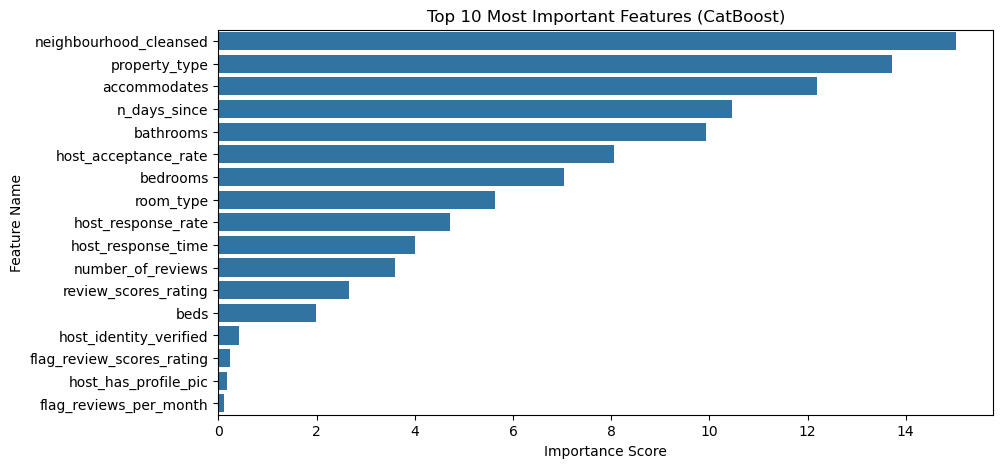

In [204]:
feature_importance = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame for sorting and visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)  # Get top 10

# Display the top 10 features
print(importance_df)

# Plot the feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 10 Most Important Features (CatBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

## Results

In [205]:
rmse_results = pd.DataFrame({
    "Model": [
        "OLS", 
        "Lasso", 
        "Lasso (GridSearchCV)",
        "Random Forest",
        "CART",
        "GBM Boosting",
        "MLP Regressor",
        "CatBoost Regressor"
    ],
    "Training RMSE": [
        model2_train_rmse,         # OLS training RMSE
        rmse_Lasso_train,          # Lasso training RMSE
        model7_level_work_rmse,    # Lasso (GridSearchCV) training RMSE
        rmse_rf_train,             # Random Forest training RMSE
        rmse_cart_train,           # CART training RMSE
        rmse_gbm_train,            # GBM training RMSE
        mlp_train_rmse,             # MLP training RMSE
        catboot_rmse_train         # CatBoost training RMSE
    ],
    "Holdout RMSE": [
        model2_test_rmse,          # OLS test RMSE from CV folds
        rmse_Lasso_test,           # Lasso test RMSE
        model7_level_holdout_rmse, # Lasso (GridSearchCV) holdout RMSE
        rmse_rf_hold,             # Random Forest holdout RMSE
        rmse_cart_holdout,         # CART holdout RMSE
        rmse_gbm_holdout,          # GBM holdout RMSE
        mlp_rmse_holdout,          # MLP holdout RMSE
        catboot_holdout_rmse       # CatBoost holdout RMSE
    ]
})

# Print the results table
print(rmse_results)

                  Model  Training RMSE  Holdout RMSE
0                   OLS     114.106198    121.624042
1                 Lasso     100.555182    133.028446
2  Lasso (GridSearchCV)     116.638997    100.776692
3         Random Forest     110.247099    101.036873
4                  CART      69.522562    132.179169
5          GBM Boosting      88.259464    124.408528
6         MLP Regressor      97.573471     98.846540
7    CatBoost Regressor      76.376189     98.506254


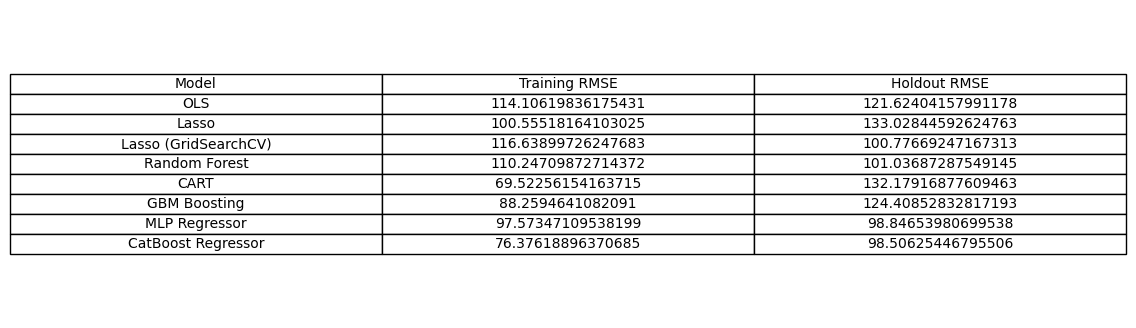

In [206]:
fig, ax = plt.subplots(figsize=(12, 4))  # adjust the size as needed

# Hide axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create a table from the DataFrame
table = ax.table(
    cellText=rmse_results.values,
    colLabels=rmse_results.columns,
    cellLoc='center',
    loc='center'
)

# Optionally, adjust the table properties for a better look:
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the figure as an image file
plt.savefig("rmse_results_table.png", bbox_inches='tight', dpi=300)
plt.show()

## CatBoost Regressor is the best, MLP closer